In [ ]:
from ecell4 import *
from ecell4.extra import ensemble
import math
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
rng = GSLRandomNumberGenerator()

simrun =10
voxelr=0.05
duration = 500
L=0.2
Da = 0#0.1
Db = 0.1
D=Da+Db
koff = 0.02
kon = 0.1
Nb0 = 1
Na0=150
V1 = L**3
dt = 10
#kd= 4.0*math.pi*D*2*voxelr
ka = 0#koff/(1-(koff/kd))
w = spatiocyte.SpatiocyteWorld(Real3(L,L,L),voxelr,rng) 
wv=w.calculate_volume(Real3(L,L,L),voxelr)
kon = kon#/wv

print('L={:f}\n Rvoxel={:f}\n actual volume={:f}'.format(L,voxelr,wv))
print('kon={:f}\n koff={:f}\n ka={:f}'.format(kon,koff,ka))
print('simulation run {:d}'.format(simrun)) 

def draw_time(w):
    k = kon
    Ng = w.size() - w.num_voxels() # total No. voxel-total no. species=empty voxels
    p = k #* Ng / (w.size()-Nb0)
    r = rng.uniform(0, 1)  #XXX: Update me
    tau = math.log(1./r)/p
    return w.t() + tau,Ng

def do_reaction(w):
    Ng = w.size() - w.num_voxels() 
    #print w.size(),Ng
    na =w.num_molecules_exact(Species("A"))
    if ((Ng+na+Nb0)!=w.size()):  print 'error',Ng+na,na, w.size()
    w.add_molecules(Species("A"), 1)   
    
def create_model(Da,Db,voxelr,ka): 
    with species_attributes():
        A | {'D': str(Da), 'radius':str(voxelr)}
        #B | {'D': str(Db), 'radius':str(voxelr)}
    #with reaction_rules():
    #    A + B > B | ka
    return get_model()

def create_modelODE(D,koff,kon,rm): #sturock model
    with species_attributes():
        A | {'D': str(D), 'radius':str(rm)}
        B | {'D': str(0), 'radius':str(rm)}
    with reaction_rules():
        #A + B > B | koff
        ~A > A | kon
    return get_model()

def singlerun1(Na,run): #correct model
    rng.seed(run)
    model = create_model(Da,Db,voxelr,ka)
    w = spatiocyte.SpatiocyteWorld(Real3(L,L,L),voxelr,rng) 
    if run==0: print 'total voxels',w.size()
    w.bind_to(model)
    w.add_molecules(Species("A"), Na0)
    #w.add_molecules(Species("B"),Nb0)
    #V = w.get_volume()
    sim = spatiocyte.SpatiocyteSimulator(model, w)    
    T,Ng = draw_time(w)
    #print(T, sim.next_time())
    data = []
    index = 0
    i=1
    while (sim.t() <= tt[-1]) and Ng!=5:
        Ng = w.size() - w.num_voxels() 
        if sim.next_time() < T:          
            sim.step()
            if len(sim.last_reactions()) > 0:
                T,Ng = draw_time(w)
        else:
            sim.step(T)
            do_reaction(w)
            T,Ng = draw_time(w)
        if sim.t()>=tt[i] :
            Na[i]+=w.num_molecules_exact(Species("A"))
            i+=1
            #np.delete(time,time[i])
    return Na

def singlerun2(Na,run): #sturrock model
    rng.seed(run)
    f = spatiocyte.SpatiocyteFactory(voxelr)
    w = f.create_world()
    #V = w.get_volume()
    k0 = k2/w.size()
    #print k2,w.size(),V
    model = create_model2(Da,Db,voxelr,ka,k0)
    w.bind_to(model)
    w.add_molecules(Species("A"), Na0)
    w.add_molecules(Species("B"),Nb0)
    sim = f.create_simulator(w)
    obs = FixedIntervalNumberObserver(dt, 'A')
    sim.run(duration+1,obs)
    data = np.array(obs.data())[:,1]
    Na  = np.array([Na[x]+y for x,y in enumerate(data)])
    #Nv = w.col_size()*w.layer_size()*w.row_size()
    return Na,w.calculate_volume(Real3(L,L,L),voxelr)

tt = np.arange(0,duration+1,dt)
Na = np.zeros(len(tt))
for i in range(int(simrun)):
    Na = singlerun1(Na,i)
Na = Na/float(simrun) #not concentration
name = '/home/chew/wrk/ecellwork/data/sturrockrxn02_rv{:.4f}_normprate.csv'.format(voxelr)
#fn = open(name,'w')
#np.savetxt(fn,[tt,Na],delimiter=',',fmt='%s')
#fn.close()
print 'saving in ',name
print 'mean Na at last few points',np.mean(Na[-20:])
mode=create_modelODE(D,koff,kon/V1,voxelr)
ode = ensemble.ensemble_simulations(t=duration,n=1,y0={'A': Na0,'B':Nb0},volume=V1, model=mode, solver=("ode"),method='serial',return_type='array')
datode = np.array(ode)[0]
plt.plot(datode[:,0],datode[:,1])
plt.plot(tt,Na,'.')


4.84013451599
4.87165808841
4.92712412396


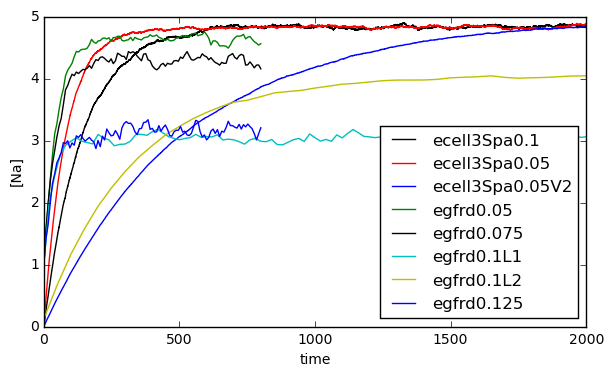

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#rad=[0.0125,0.0500,0.125]
rad=[0.0125,0.0500,0.125]
clrs = ['r','g','b','c','k']
'''
for i in range(len(rad)):
    print rad[i]
    dat = np.loadtxt('/home/chew/wrk/ecellwork/data/sturrockrxn02_rv{0:0.4f}_normprate.csv'.format(rad[i]),dtype='str',delimiter=',')
    y=[float(e) for e in dat[1]]
    x=[float(e) for e in dat[0]]
    print np.mean(y[-20:])
    plt.plot(x,y,c=clrs[i],linestyle='',marker='.',label='r={0:0.4f}'.format(rad[i]))
'''
dat=np.loadtxt('/home/chew/wrk/spatiocyte/examples/sturrock/Spa0.1.csv',delimiter=',',skiprows=1)
plt.plot(dat[:,0],dat[:,1]/2.89631,'k-',label='ecell3Spa0.1')  
print np.mean(dat[:,1][-100:]/2.89631)
dat=np.loadtxt('/home/chew/wrk/spatiocyte/examples/sturrock/Spa0.05.csv',delimiter=',',skiprows=1)
plt.plot(dat[:,0],dat[:,1]/1.66312,'r-',label='ecell3Spa0.05')  
print np.mean(dat[:,1][-100:]/1.66312)
dat=np.loadtxt('/home/chew/wrk/spatiocyte/examples/sturrock/Spa0.05V2.csv',delimiter=',',skiprows=1)
plt.plot(dat[:,0],dat[:,1]/10.5161,'b-',label='ecell3Spa0.05V2')  
print np.mean(dat[:,1][-100:]/10.5161)

dat = np.loadtxt('/home/chew/wrk/ecellwork/data/sturrockmean0.0500',dtype='str',delimiter=',')
plt.plot(dat[:,0],dat[:,1],'g-',label='egfrd0.05')     
dat = np.loadtxt('/home/chew/wrk/ecellwork/data/sturrockmean0.0750',dtype='str',delimiter=',')
plt.plot(dat[:,0],dat[:,1],'k-',label='egfrd0.075')     
dat = np.loadtxt('/home/chew/wrk/ecellwork/data/sturrockmean0.1000L1',dtype='str',delimiter=',')
plt.plot(dat[:,0],dat[:,1],'c-',label='egfrd0.1L1')  
dat = np.loadtxt('/home/chew/wrk/ecellwork/data/sturrockmean0.1000L2',dtype='str',delimiter=',')
y=[float(i)/(2**3) for i in dat[:,1]]
x=[float(i) for i in dat[:,0]]
plt.plot(x,y,'y-',label='egfrd0.1L2')  
dat = np.loadtxt('/home/chew/wrk/ecellwork/data/sturrockmean0.1250',dtype='str',delimiter=',')
plt.plot(dat[:,0],dat[:,1],'b-',label='egfrd0.125')   
tt=np.arange(0,2000,1)
plt.plot(tt,[5]*len(tt))
#dat = np.loadtxt('/home/chew/wrk/ecellwork/data/sturrock0.100.csv',dtype='str',delimiter=',')    
#plt.plot(dat[0],dat[1],'o')
plt.xlabel('time')
plt.ylabel('[Na]')
#plt.title("L={4:1.0f},Da={0:0.1f},ka={1:0.2f},k2={3:0.1f},Nb={5:1.0f}".format(Da,ka,kd,k2,L,Nb0))
fig = plt.gcf()
fig.set_size_inches(7,4)
plt.legend(loc='best')
#plt.savefig("figure/1st_order_production_2nd_order_degradation_Sturrock_rxn_Ks.png",format='png',dpi=100)
plt.xlim(0 ,2000)
plt.show()


In [98]:
0.5*(0.05+0.1)

0.07500000000000001

In [94]:
nt=4
(0.3/4/3.14/nt)**(1./3)

0.18142224689457484

In [104]:
print L/(2*40)


0.0125


In [108]:
5*1.66

8.299999999999999

In [109]:
4.9/1.66

2.951807228915663

In [126]:
w.calculate_volume(Real3(1,1,1),0.125)

2.386485386504598

In [119]:
tuple(w.calculate_shape(Real3(1,1,1),0.125))

(6, 6, 6)

In [127]:
x,y,z=tuple(w.actual_lengths())

In [128]:
print x,y,z,x*y*z

1.22474487139 1.29903810568 1.5 2.3864853865


In [13]:
a=np.array([0,1,2,3])

In [14]:
np.delete(a,-1)

array([0, 1, 2])